In [496]:
import time
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2017) # set random seed value to get reproducible results
from copy import deepcopy

In [497]:
# store start time to get execution time of entire script
start_time = time.time()

### Load Data

In [498]:
grouping = 'stimulants'
# grouping = 'opioids'

df = pd.read_csv(grouping + '.csv', index_col=[0])
print(df.shape)
df.head()

(4524, 37)


,engage30,init,female_cd,nonwhite_cd,unemplmt_cd,prsatx_cd,TRIg_0_cd,TMIg_0_cd,SESg_0_cd,gvsg_cd,tsd_0_cd,und15_cd,CWSg_0_cd,srprobg_cd,dldiag_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,suicprbs_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,homeless_0_cd,S6_cd,gcsg_0_cd,ncar_cd,SFSg_0_cd,Raceg4_cd_gr_1,Raceg4_cd_gr_2,Raceg4_cd_gr_3,Raceg4_cd_gr_4,loc_cd_gr_1,loc_cd_gr_2,loc_cd_gr_3,loc_cd_gr_6,loc_cd_gr_9
0,1,1,0,0,1,1,0,1,0,2,1,1,0,1,1,2,1,2,1,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,1,2,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0
9,0,1,0,0,0,0,0,2,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0
11,1,1,0,0,0,0,1,1,0,2,0,1,0,1,1,1,2,2,1,0,2,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
16,1,1,0,0,0,0,0,1,0,2,1,1,0,1,1,2,1,2,2,0,2,2,2,1,1,2,1,0,1,0,0,0,1,0,0,0,0


### Outcome Distribution (percentage)

In [499]:
df['init'].value_counts()

1    4020
0     504
Name: init, dtype: int64

In [500]:
df['engage30'].value_counts()

1    2860
0    1664
Name: engage30, dtype: int64

### Modelling

In [501]:
def run_model(model, data, outcome):
    X = data.drop(columns=[outcome])
    y = data[outcome]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    print("X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape) 
    
    # combine them back for resampling
    train_data = pd.concat([X_train, y_train], axis=1)
    # separate minority and majority classes
    negative = train_data[train_data[outcome] == 0]
    positive = train_data[train_data[outcome] == 1]
    
    # downsample majority
    pos_downsampled = resample(positive, 
                               replace=False, # sample without replacement
                               n_samples=len(negative)) # match number in minority class
    
    # combine minority and downsampled majority
    downsampled = pd.concat([negative, pos_downsampled])
    X_train = downsampled.drop(columns=[outcome])
    y_train = downsampled[outcome]
    
    print("Downsampled training set outcome distribution:\n", y_train.value_counts().to_frame())
    
    res = cross_validate(model, X_train, y_train, return_estimator=True, cv=5)
    top_model_ind = list(res['test_score']).index(max(list(res['test_score']))) # get index of top performing model
    model = res['estimator'][top_model_ind] # get top performing model
    
    y_pred = model.predict_proba(X_test)[:,1] 
    
    y_pred_bin = deepcopy(y_pred)
    y_pred_bin[y_pred_bin < 0.5] = 0
    y_pred_bin[y_pred_bin >= 0.5] = 1

    accuracy = metrics.accuracy_score(y_test, y_pred_bin)
    f1 = metrics.f1_score(y_test, y_pred_bin)
    auc = metrics.roc_auc_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred_bin)
    recall = metrics.recall_score(y_test, y_pred_bin)

    print("Accuracy:", accuracy)
    print("F1:", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    print("AUC:", auc)
    
    try:
        # random forest
        feature_importance = model.feature_importances_ 
        label = "RF-" + outcome
    except AttributeError:
        # logistic regression
        feature_importance = np.exp(model.coef_[0]) # hazard ratios
        label = "LR-" + outcome
    
    ns_probs = [0 for _ in range(len(y_test))]
    # calculate roc curves
    ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, y_pred)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(label)
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
        
    features = X.columns
    feature_importance_df = pd.DataFrame({"feature": features, label: feature_importance})
    feature_importance_df = feature_importance_df.set_index('feature')
    return feature_importance_df, [label, accuracy, f1, precision, recall, auc, X_train.shape[0]]

In [502]:
def get_logistic_regression_features(X):
    # one-hot encode all variables (except binary vars) to get hazards across groups, drop reference group
    result = X.copy()
    
    for col in result.columns:
        if not np.isin(result[col], [0, 1]).all(): # if non-binary
            one_hot = pd.get_dummies(result[col], prefix=col)
            one_hot = one_hot.loc[:, ~one_hot.columns.str.endswith('1')] # drop group and use as reference
            result = result.drop(col,axis = 1)
            result = result.join(one_hot)
    # print('Logistic Regression Features:', result.columns)
    return result

In [503]:
engage30 = df.drop(columns=['init'])
init = df.drop(columns=['engage30'])

In [504]:
features_random_forest = list(engage30.columns)
features_random_forest.remove('engage30')
feature_importance_random_forest = pd.DataFrame({"feature": features_random_forest})
feature_importance_random_forest = feature_importance_random_forest.set_index('feature')


features_logistic_regression = list(get_logistic_regression_features(engage30).columns)
features_logistic_regression.remove('engage30')
feature_importance_logistic_regression = pd.DataFrame({"feature": features_logistic_regression})
feature_importance_logistic_regression = feature_importance_logistic_regression.set_index('feature')

performance = []

X_train: (3393, 35) X_test: (1131, 35) y_train: (3393,) y_test: (1131,)
Downsampled training set outcome distribution:
    engage30
1      1242
0      1242
Accuracy: 0.5985853227232537
F1: 0.6646971935007385
Precision: 0.6976744186046512
Recall: 0.6346967559943583
AUC: 0.6230272261178216


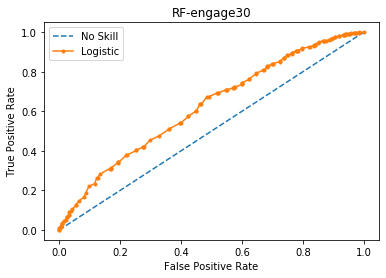

In [505]:
feat_imp, perf_stats = run_model(RandomForestClassifier(), engage30, 'engage30')
feature_importance_random_forest = feature_importance_random_forest.join(feat_imp)
performance.append(perf_stats)

X_train: (3393, 50) X_test: (1131, 50) y_train: (3393,) y_test: (1131,)
Downsampled training set outcome distribution:
    engage30
1      1252
0      1252
Accuracy: 0.5809018567639257
F1: 0.6414523449319213
Precision: 0.703150912106136
Recall: 0.5897079276773296
AUC: 0.5945099720485572


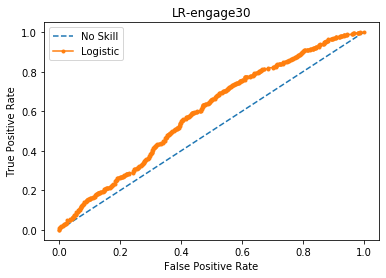

In [506]:
engage30_logistic_regression = get_logistic_regression_features(engage30)

feat_imp, perf_stats = run_model(LogisticRegression(max_iter=1000), engage30_logistic_regression, 'engage30')
feature_importance_logistic_regression = feature_importance_logistic_regression.join(feat_imp)
performance.append(perf_stats)

X_train: (3393, 35) X_test: (1131, 35) y_train: (3393,) y_test: (1131,)
Downsampled training set outcome distribution:
    init
1   385
0   385
Accuracy: 0.6136162687886826
F1: 0.738166566806471
Precision: 0.9375951293759512
Recall: 0.6086956521739131
AUC: 0.7112922243996412


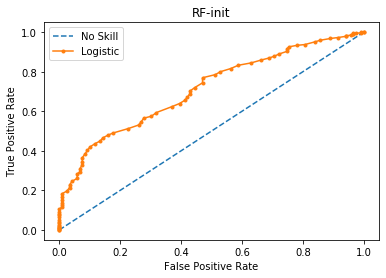

In [507]:
feat_imp, perf_stats = run_model(RandomForestClassifier(), init, 'init')
feature_importance_random_forest = feature_importance_random_forest.join(feat_imp)
performance.append(perf_stats)

X_train: (3393, 50) X_test: (1131, 50) y_train: (3393,) y_test: (1131,)
Downsampled training set outcome distribution:
    init
1   368
0   368
Accuracy: 0.6091954022988506
F1: 0.7324455205811137
Precision: 0.9208523592085236
Recall: 0.6080402010050251
AUC: 0.6553613656517884


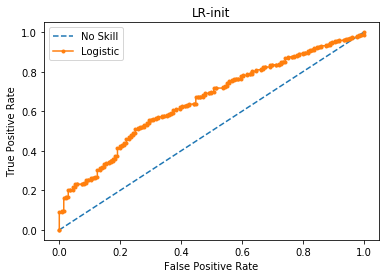

In [508]:
init_logistic_regression = get_logistic_regression_features(init)

feat_imp, perf_stats = run_model(LogisticRegression(max_iter=1000), init_logistic_regression, 'init')
feature_importance_logistic_regression = feature_importance_logistic_regression.join(feat_imp)
performance.append(perf_stats)

### Feature Importance Analysis

In [509]:
def mag_from_one(row, groups):
    result = 0
    for group in groups:
        temp = abs(row[group] - 1)
        if temp > result:
            result = row[group]
    return result

def sel_max(row, groups):
    result = 0
    for group in groups:
        if row[group] > result:
            result = row[group]
    return result

feature_importance_random_forest['max'] = feature_importance_random_forest.apply(lambda row: sel_max(row, feature_importance_random_forest.columns), axis=1)
feature_importance_random_forest = feature_importance_random_forest.sort_values(by='max', ascending=False)

feature_importance_logistic_regression['dist-from-1'] = feature_importance_logistic_regression.apply(lambda row: mag_from_one(row, feature_importance_logistic_regression.columns), axis=1)
feature_importance_logistic_regression = feature_importance_logistic_regression.sort_values(by='dist-from-1', ascending=False)

In [510]:
feature_importance_random_forest.head(10) 

,RF-engage30,RF-init,max
feature,,,
gcsg_0_cd,0.044004,0.045262,0.045262
cjsig_0_cd,0.044643,0.043275,0.044643
TMIg_0_cd,0.044175,0.042757,0.044175
TRIg_0_cd,0.043957,0.043129,0.043957
gvsg_cd,0.043697,0.042068,0.043697
srig_0_cd,0.042771,0.036203,0.042771
dssg_0_cd,0.042452,0.040401,0.042452
adhdg_0_cd,0.041147,0.040073,0.041147
SFSg_0_cd,0.041016,0.038557,0.041016


In [511]:
feature_importance_logistic_regression.head(10) 

,LR-engage30,LR-init,dist-from-1
feature,,,
loc_cd_gr_1,1.381983,3.624388,3.624388
CWSg_0_cd_2,0.831926,2.306612,2.306612
loc_cd_gr_2,0.786895,2.116944,2.116944
unemplmt_cd,0.735021,1.976403,1.976403
female_cd,0.807976,1.840828,1.840828
loc_cd_gr_9,1.482369,0.435736,1.482369
cjsig_0_cd_2,1.380681,1.515980,1.380681
S6_cd,1.380407,1.351441,1.380407
dldiag_cd,1.291413,1.248816,1.291413


In [512]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(grouping + '_feature_importance.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
feature_importance_random_forest.to_excel(writer, sheet_name='RF - Rank Order')
feature_importance_logistic_regression.to_excel(writer, sheet_name='LR - Hazard Ratios')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

### Performance Statistics

In [513]:
pd.DataFrame(data=performance, columns=['model-outcome', 'Accuracy', 'F1', 'Precision', 'Recall', 'AUC', 'Training Size'])

,model-outcome,Accuracy,F1,Precision,Recall,AUC,Training Size
0,RF-engage30,0.598585,0.664697,0.697674,0.634697,0.623027,2484
1,LR-engage30,0.580902,0.641452,0.703151,0.589708,0.594510,2504
2,RF-init,0.613616,0.738167,0.937595,0.608696,0.711292,770
3,LR-init,0.609195,0.732446,0.920852,0.608040,0.655361,736


In [514]:
total_seconds = int(time.time() - start_time)
hours = total_seconds // (60 * 60)
minutes = (total_seconds - hours*60) // 60
seconds = (total_seconds - hours*60) % 60
print("--- " + str(minutes) + " minutes " + str(seconds) + " seconds ---")

--- 0 minutes 6 seconds ---
